# Homework

---

### Q1

The *Gibbs sampler* in class for the prior $p(\theta,\tau) \propto 1$ was created by alternatingly sampling from the *full conditional* $p(\theta|\tau,\textbf{x})$ *normal* and  $p(\tau|\theta,\textbf{x})$ *gamma* distributions. Create this *Gibbs sampler* so your code can be used for the sample `x = stats.norm(loc=m, scale=s).rvs(size=n)` for any arbitrary `n`, `m`, and `s`.

*Use the code below or your own code to <u>provide a demonstration of Bayesian inference<u> for this data and model specification.*


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# Function to implement the Gibbs sampler
def gibbs_sampler(n, m, s, C=2, G=10000, burn_in=20, demo=120):
    # Generate the sample from the normal distribution
    x = stats.norm(loc=m, scale=s).rvs(size=n)

    # Initialize theta and tau
    theta = np.zeros([C, G])
    tau = np.zeros([C, G])
    theta[:, 0] = 1000  # initial guess for theta
    tau[:, 0] = 1  # initial guess for tau

    for c in range(C):
        for g in range(1, G):
            # Sample tau given theta and x (Gamma distribution)
            alpha_tau = n / 2  # Shape parameter for Gamma distribution
            beta_tau = np.sum((x - theta[c, g-1])**2) / 2  # Rate parameter for Gamma distribution
            tau[c, g] = np.random.gamma(alpha_tau, 1 / beta_tau)

            # Sample theta given tau and x (Normal distribution)
            mu_theta = np.mean(x)
            var_theta = tau[c, g] / n
            theta[c, g] = np.random.normal(mu_theta, np.sqrt(var_theta))

    # Plot results
    fig, ax = plt.subplots(1, 4, figsize=(14, 3))
    ax[0].set_title("$\\theta$ Burn-In")
    ax[1].set_title("$\\tau$ Burn-In")
    ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
    ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

    for c in range(C):
        ax[0].plot(theta[c, :burn_in], label="$\\theta$ Chain " + str(c))
        ax[1].plot(tau[c, :burn_in], label="$\\tau$ Chain " + str(c))
        ax[2].plot(np.arange(burn_in, demo, dtype=int), theta[c, burn_in:demo], label="$\\theta$ Chain " + str(c))
        ax[3].plot(np.arange(burn_in, demo, dtype=int), tau[c, burn_in:demo], label="$\\tau$ Chain " + str(c))

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()
    plt.show()

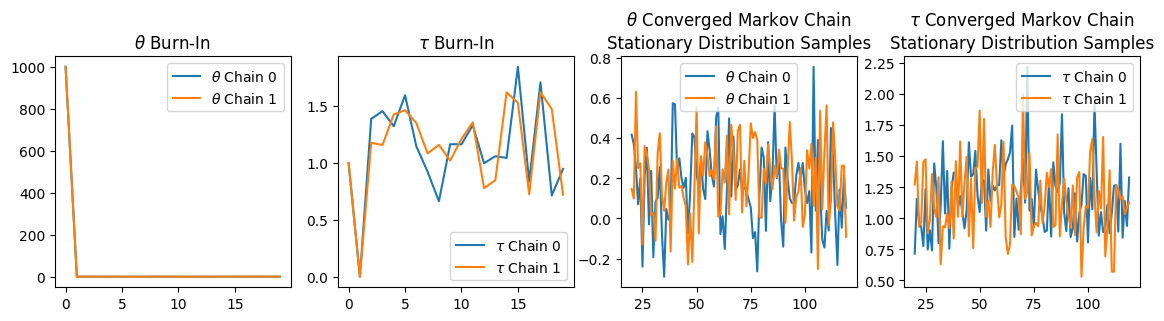

In [4]:
n = 30  # Sample size
m, s = 0, 1  # Mean, SD of the normal distribution

# Run Gibbs sampler
gibbs_sampler(n, m, s)

### Q2

Derive the *full conditional distributions* $p(\tau|\theta, \mathbf{x})$ and $p(\theta|\tau, \mathbf{x})$ if $p(\theta)$ is $N(\theta_0, \tau_0)$ and $p(\tau) \propto \tau^{\frac{\alpha}{2}-1} e^{- \frac{\lambda}{2} \tau}$.

*Explain how to equate $\alpha$ and $\lambda$ with controlling the amount and nature of information the prior contributes to the posterior. How can we interpret these as controlling a "number of data points" contributed by the prior relative to the number of data points contributed to the posterior through the likelihoood?*

Create an updated version of the *Gibbs sampler* for $N(\theta_0, \tau_0)$ and $\textrm{gamma}(\textrm{shape}=\frac{\alpha}{2}, \textrm{rate}=\frac{\lambda}{2})$ priors for $p(\theta)$ and $p(\tau)$ respectively.

*Demonstrate how changing the prior hyperparameters influences the posterior relative to the sample and the likelihood.*


Given the following priors:

- $ p(\theta) = N(\theta_0, \tau_0) $, i.e., $ \theta \sim \mathcal{N}(\theta_0, \tau_0) $.
- $ p(\tau) \propto \tau^{\frac{\alpha}{2}-1} e^{- \frac{\lambda}{2} \tau} $, i.e., $ \tau \sim \text{Gamma}\left(\frac{\alpha}{2}, \frac{\lambda}{2}\right) $.

I will derive the full conditional distributions:

- $ p(\tau | \theta, \mathbf{x})$
- $ p(\theta | \tau, \mathbf{x}) $



---


**Full Conditional for $ p(\tau | \theta, \mathbf{x}) $:**

We begin by writing the joint distribution $ p(\theta, \tau | \mathbf{x}) $, which is proportional to the product of the likelihood and priors:

$
p(\theta, \tau | \mathbf{x}) \propto p(\mathbf{x} | \theta, \tau) p(\theta) p(\tau)
$

For a sample $ \mathbf{x} = (x_1, x_2, \dots, x_n) $, the likelihood is:

$
p(\mathbf{x} | \theta, \tau) = \prod_{i=1}^{n} \mathcal{N}(x_i | \theta, \tau) = \prod_{i=1}^{n} \frac{1}{\sqrt{2 \pi \tau}} \exp\left(-\frac{(x_i - \theta)^2}{2 \tau}\right)
$

Thus, the likelihood is:

$
p(\mathbf{x} | \theta, \tau) \propto \tau^{-\frac{n}{2}} \exp\left(-\frac{1}{2\tau} \sum_{i=1}^{n} (x_i - \theta)^2\right)
$

Now, using the priors:

$
p(\theta) = \mathcal{N}(\theta | \theta_0, \tau_0) \propto \exp\left(-\frac{1}{2\tau_0}(\theta - \theta_0)^2\right)
$
$
p(\tau) \propto \tau^{\frac{\alpha}{2} - 1} \exp\left(-\frac{\lambda}{2} \tau\right)
$

Combining everything, we get:

$
p(\theta, \tau | \mathbf{x}) \propto \tau^{-\frac{n}{2}} \exp\left(-\frac{1}{2\tau} \sum_{i=1}^{n} (x_i - \theta)^2\right) \cdot \exp\left(-\frac{1}{2\tau_0}(\theta - \theta_0)^2\right) \cdot \tau^{\frac{\alpha}{2} - 1} \exp\left(-\frac{\lambda}{2} \tau\right)
$

To obtain the full conditional for $ \tau $, we integrate out $\theta $, which gives us the distribution for $ \tau $:

$
p(\tau | \theta, \mathbf{x}) \propto \tau^{\frac{n}{2} + \frac{\alpha}{2} - 1} \exp\left(-\left[\frac{1}{2} \sum_{i=1}^{n} (x_i - \theta)^2 + \frac{\lambda}{2} \right] \tau \right)
$

This is a Gamma distribution, and we can identify the parameters of the Gamma distribution:

$
\tau | \theta, \mathbf{x} \sim \text{Gamma}\left(\frac{n}{2} + \frac{\alpha}{2}, \frac{1}{\sum_{i=1}^{n} (x_i - \theta)^2 + \lambda}\right)
$


---


**Full Conditional for $ p(\theta | \tau, \mathbf{x})$:**

Now, for the full conditional of \( \theta \), we look at the joint distribution $ p(\theta, \tau | \mathbf{x}) $, keeping $ \tau $ fixed. The likelihood for $ \theta $ is:

$
p(\mathbf{x} | \theta, \tau) \propto \exp\left(-\frac{1}{2\tau} \sum_{i=1}^{n} (x_i - \theta)^2\right)
$

The prior for $\theta$ is:

$
p(\theta) \propto \exp\left(-\frac{1}{2\tau_0}(\theta - \theta_0)^2\right)
$

Thus, the full conditional for $\theta$ is:

$
p(\theta | \tau, \mathbf{x}) \propto \exp\left(-\frac{1}{2\tau} \sum_{i=1}^{n} (x_i - \theta)^2\right) \cdot \exp\left(-\frac{1}{2\tau_0}(\theta - \theta_0)^2\right)
$

This is a Normal distribution, and we can identify the parameters of the Normal distribution:

$
\theta | \tau, \mathbf{x} \sim \mathcal{N}\left( \frac{\frac{1}{\tau_0} \theta_0 + \frac{1}{\tau} \sum_{i=1}^{n} x_i}{\frac{1}{\tau_0} + \frac{n}{\tau}}, \frac{1}{\frac{1}{\tau_0} + \frac{n}{\tau}} \right)
$


---



**Hyperparameters $ \alpha $ and $\lambda $:**

- The hyperparameter $ \alpha$ controls the **shape** of the prior distribution for $\tau $. Larger values of $\alpha $ correspond to stronger prior belief about the scale of $\tau$, implying that the prior has a stronger influence on the posterior. This can be interpreted as adding "more data points" through the prior's contribution to the posterior.
- The hyperparameter $ \lambda $ controls the **rate** of the prior distribution for $\tau $. Larger values of $\lambda $ correspond to a stronger prior belief that $ \tau$ should be small, which can influence the posterior towards smaller values of $ \tau $.

In Bayesian inference, the prior contributes to the posterior distribution by incorporating prior beliefs (through $ \alpha $ and $ \lambda $) in a way that influences the posterior in relation to the likelihood. By adjusting these hyperparameters, we control the "effective number of data points" the prior contributes relative to the data itself.

In [5]:
def gibbs_sampler_updated(n, m, s, theta_0, tau_0, alpha, lambda_ , C=2, G=10000, burn_in=20, demo=120):
    # Generate the sample from the normal distribution
    x = stats.norm(loc=m, scale=s).rvs(size=n)

    # Initialize theta and tau
    theta = np.zeros([C, G])
    tau = np.zeros([C, G])
    theta[:, 0] = 1000  # initial guess for theta
    tau[:, 0] = 1  # initial guess for tau

    for c in range(C):
        for g in range(1, G):
            # Sample tau given theta and x (Gamma distribution)
            alpha_tau = n / 2 + alpha / 2  # Shape parameter for Gamma distribution
            beta_tau = np.sum((x - theta[c, g-1])**2) / 2 + lambda_  # Rate parameter for Gamma distribution
            tau[c, g] = np.random.gamma(alpha_tau, 1 / beta_tau)

            # Sample theta given tau and x (Normal distribution)
            mu_theta = np.mean(x)  # Mean of the normal distribution
            var_theta = tau[c, g] / n  # Variance of the normal distribution
            theta[c, g] = np.random.normal(mu_theta, np.sqrt(var_theta))

    # Plot results
    fig, ax = plt.subplots(1, 4, figsize=(14, 3))
    ax[0].set_title("$\\theta$ Burn-In")
    ax[1].set_title("$\\tau$ Burn-In")
    ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
    ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

    for c in range(C):
        ax[0].plot(theta[c, :burn_in], label="$\\theta$ Chain " + str(c))
        ax[1].plot(tau[c, :burn_in], label="$\\tau$ Chain " + str(c))
        ax[2].plot(np.arange(burn_in, demo, dtype=int), theta[c, burn_in:demo], label="$\\theta$ Chain " + str(c))
        ax[3].plot(np.arange(burn_in, demo, dtype=int), tau[c, burn_in:demo], label="$\\tau$ Chain " + str(c))

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()
    plt.show()

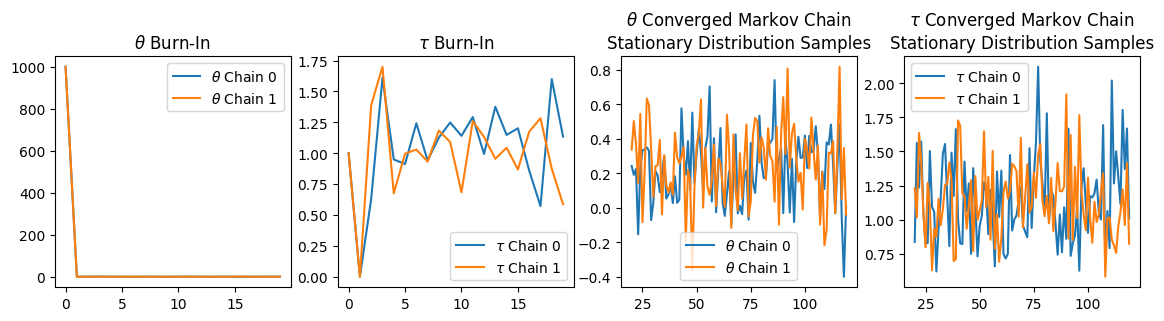

In [6]:
# Set parameters
n = 30  # Sample size
m = 0  # Mean of the normal distribution
s = 1  # Standard deviation of the normal distribution
theta_0 = 0  # Prior mean for theta
tau_0 = 1  # Prior variance for theta
alpha = 2  # Prior shape parameter for tau
lambda_ = 1  # Prior rate parameter for tau

# Run Gibbs sampler with updated priors
gibbs_sampler_updated(n, m, s, theta_0, tau_0, alpha, lambda_)

### Q3

*Read the following "conversation". My reactions to this initial text I was provied with are the colored font. Then either (A) provide an analagous derivation of this result for the multinomial-Dirichlet specification, or (B) just report that if the prior is a proper distribution then the posterior is proportional to the joint distribution as Bayes Theorem tells us and describe how one might therefore identify the exact distribution of the posterior by just looking at the joint but that finally all this is moot and beside the point because as Bayesians we're going to trade any functional forms of distributions for samples from those distributions to just make histograms and belief (credible interval probability) statements based on those anyway...*

Suppose we have the following model setup:
\begin{align*}
    x_1,...,x_n &\overset{iid}{\sim} \text{Bernoulli}(\theta)\\
    \theta &\sim \text{Beta}(a, b)
\end{align*}

The joint likelihood distribution of ~~x_1,...,x_n~~ <span style='color:red'> $\sum_i x_i$</span> $| \theta$ is $\text{Binomial}(n, \theta)$. Now, let's consider the posterior:
\begin{align*}
    p(\theta | x_1,...,x_n) &= \frac{p(x_1,...,x_n | \theta)p(\theta)}{p(x_1,...,x_n)} = \color{red}{\frac{p(\mathbf{x} | \theta)p(\theta)}{p(\mathbf{x})}}\\
    &= \frac{p(x_1,...,x_n | \theta)p(\theta)}{\int p(x_1,...,x_n | \theta )p(\theta) d\theta} = \color{red}{\frac{p(\mathbf{x}| \theta)p(\theta)}{\int p(\mathbf{x} | \theta )p(\theta) d\theta}}
\end{align*}

We can directly calculate the above if the denominator is finite. We tend to use proportionality arguments in this class, but to build some intuition <span style='color:red'>Bayes theorem is $p(\theta | \mathbf{x}) = \frac{p(\mathbf{x} | \theta )p(\theta)}{p(x)}$ and (if we know $\mathbf{x}$) then $p(\mathbf{x})$ is a constant so we must gather all $\theta$ related terms in our mathematical expression (dropping anything else which is any other constant) and see if we know of any statistical distribution that when scaled by a constant could exactly replicate our math as a function of $\theta$</span>, <span style='color:blue'>but if by "intuition" you mean the next 10 lines of derivation because you refuse to believe that the posterior is proportional to the joint (for proper priors) as Bayes Theorem claims</span> let's formally calculate that integral for the Beta-Binomial problem:

$\scriptsize
\begin{align*}
    \int p(\overset{\color{red}{\textrm{You meant } \sum_i x_i}}{x_1,...,x_n} | \theta )p(\theta) d\theta &= \int_0^1 \color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}} \overset{\color{blue}{\textrm{just this alone is a Bernoulli likelihood}}}{\theta^{\sum_i x_i}(1-\theta)^{n-\sum_i x_i}} \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\theta^{a-1}(1-\theta)^{b-1}d\theta \\
    &= \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\int_0^1 \theta^{\sum_i x_i + a - 1}(1-\theta)^{n-\sum_i x_i + b - 1}d\theta \\
    &= \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}\int_0^1 \frac{\Gamma(a+b+n)}{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}\theta^{\sum_i x_i + a - 1}(1-\theta)^{n-\sum_i x_i + b - 1}d\theta \\
    &= \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}\\& \text{ (because we have written the density formula above, which integrates to } 1)\\    
  & \color{blue}{\textrm{(But why stop there shouldn't we prove the integral is equal to 1 for "intuition"?)}}\\
    & \color{red}{\textrm{(if "intuition" may assume a density has area 1 then prove or believe Bayes Theorem)}}\\
    & \color{purple}{\textrm{Proof: $p(\theta|\mathbf{x})p(\mathbf{x}) = p(\mathbf{x}|\theta)p(\theta) \Rightarrow p(\theta|\mathbf{x}) = \frac{p(\mathbf{x}|\theta)p(\theta)}{p(\mathbf{x})}$}} \\    
    & \color{green}{\textrm{(Bayes Theorem is the formula for a posterior distribution if the prior is proper)}}\\
    & \color{blue}{\textrm{(If you believe it then the posterior is proportional to the joint and must have area 1)}}\\
    & \color{red}{\textrm{(Can you recognize what distribution for $\theta$ would be proportional to the given joint?)}}\\
    & \color{green}{\textrm{(There's only gonna be one... can't be two... can you find one distribution that does it?)}}\\
\end{align*}$

Now, we can directly plug in to our Bayes formula to directly calculate the posterior:

$\begin{align*}
    p(\theta | x_1,...,x_n) &= \frac{p(x_1,...,x_n | \theta)p(\theta)}{\int p(x_1,...,x_n | \theta )p(\theta) d\theta} \\
    &= \frac{p(x_1,...,x_n | \theta)p(\theta)}{\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}} \\
    &= \frac{\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}} \overset{\color{blue}{\textrm{just this alone is a Bernoulli likelihood}}}{\theta^{\sum_i x_i}(1-\theta)^{n-\sum_i x_i}} \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\theta^{a-1}(1-\theta)^{b-1}}{\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}} \\
    &= \frac{\theta^{\sum_i x_i}(1-\theta)^{n-\sum_i x_i} \theta^{a-1}(1-\theta)^{b-1}}{\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}} \\
    &= \frac{\Gamma(a+b+n)}{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}\theta^{\sum_i x_i + a-1}(1-\theta)^{n-\sum_i x_i+b-1} \\
    &= \text{Beta}(a+ \sum_i x_i, b + n - \sum_i x_i)
\end{align*}$

<span style='color:blue'>
So the structure of this "proof" providing the right kind of "intution" you'll apparently need to feel comfortable and safe about proportionality (if believing that the posterior is proportional to the joint as Bayes Theorem claims is a step too far for you) is...</span>

$\color{green}{\require{cancel}
\begin{align}
\frac{p(\textbf{x}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{\int p(\textbf{x}|\boldsymbol{\theta})p(\boldsymbol{\theta}) d\boldsymbol{\theta}} &={} \frac{\cancel{c_xc_\theta} c p(\boldsymbol{\theta}|\textbf{x})}{\cancel{c_xc_\theta} \int c p(\boldsymbol{\theta}|\textbf{x})d \boldsymbol{\theta}}\\
&={} \frac{c p(\boldsymbol{\theta}|\textbf{x})}{ c \int \xcancel{\frac{1}{c} c} p(\boldsymbol{\theta}|\textbf{x})d \boldsymbol{\theta}} =  \frac{c p(\boldsymbol{\theta}|\textbf{x})}{ c \cancel{\int p(\boldsymbol{\theta}|\textbf{x})d \boldsymbol{\theta}}^1} = \frac{\xcancel{c} p(\boldsymbol{\theta}|\textbf{x})}{ \xcancel{c} } = p(\boldsymbol{\theta}|\textbf{x})\\
\end{align}}
$

<span style='color:blue'>
Or here's an even more direct way to show this...
</span>

$\color{red}{
\begin{align*}
\frac{p(\textbf{x}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{\int p(\textbf{x}|\boldsymbol{\theta})p(\boldsymbol{\theta}) d\boldsymbol{\theta}}
 &={} \frac{p(\boldsymbol{\theta}|\textbf{x})p(\textbf{x})}{p(\textbf{x})} \\
  &={} p(\boldsymbol{\theta}|\textbf{x})
\end{align*}}
$    



We can see that when we have ~~**conjugate** priors (where the prior and posterior have the same form)~~ <u>**just any (propor) prior**</u>, the denominator in Bayes rule amounts to any normalizing constants in the likelihood and prior (that allow for the densities to integrate to 1 times the inverse of the equivalent normalizing constant of the posterior. Once we plug this back in to Bayes formula and cancel and rearrange terms, this amounts to multiplying the normalizing constant of the posterior with the portion of the posterior that relies on the parameter. This sort of derivation isn't unique to conjugate priors; as long as we can recognize the family in which the product of the prior and likelihood belong to, the integral in the denominator can be solved by simplifying the term in the integral to the precise density (which occurs by moving normalizing constants outside of the integral, and introducing the normalizing constant for that new density). This is the technique we used to solve the integral above.

As a result, we can use a proportionality argument to skip all of these mathematical derivations. If we can recognize the functional form of the product between the likelihood and prior as being in the family of another probability distribution, then that is equivalent to moving around these normalizing constants to simplify integrals.



**Option B**

---

### Bayesian Posterior Using Proportionality:

The prior is given as a **Beta** distribution for $ \theta $, i.e., $ \theta \sim \text{Beta}(a, b) $, and the likelihood is **Binomial**. Using Bayes' Theorem, the posterior distribution is proportional to the likelihood times the prior:

$
p(\theta | \mathbf{x}) \propto p(\mathbf{x} | \theta) p(\theta)
$

This proportionality is central to Bayesian inference: we don't need to explicitly calculate the constant normalization factor (the marginal likelihood or evidence $ p(\mathbf{x}) $) because we know that the posterior is proportional to the product of the likelihood and the prior.

#### What is $ p(\mathbf{x}) $?

In Bayes' Theorem, $ p(\mathbf{x}) $ (the marginal likelihood) is a normalizing constant that ensures the posterior integrates to 1. This term is defined as:

$
p(\mathbf{x}) = \int p(\mathbf{x} | \theta) p(\theta) d\theta
$

However, in the context of conjugate priors (like the Beta-Binomial case), we often don't need to explicitly compute this integral because we can recognize that the product of the likelihood and the prior belongs to a well-known family of distributions.

#### Recognizing the Posterior Distribution:

By combining the Beta prior and the Binomial likelihood, we can identify that the posterior distribution for $ \theta $ is itself a **Beta** distribution. Specifically, the posterior $ p(\theta | \mathbf{x}) $ for a Beta prior and a Binomial likelihood is another Beta distribution:

$
p(\theta | \mathbf{x}) = \text{Beta}\left(a + \sum_i x_i, b + n - \sum_i x_i\right)
$

Thus, the posterior distribution is proportional to the **Beta** distribution, with updated parameters based on the data successes.

#### Key Insights on Proportionality:

1. **Normalization Constant**: We don't need to worry about calculating $ p(\mathbf{x}) $ because it’s simply a normalizing factor to ensure the posterior integrates to 1. We are primarily interested in the functional form of the posterior, which is given by the Beta distribution in this case.

2. **Proportionality**: Bayesian inference often relies on proportionality. If we can identify the posterior distribution by recognizing the functional form of the product of the prior and the likelihood, we can skip tedious integrations. In the Beta-Binomial case, we recognize that the posterior is a Beta distribution.

3. **Practical Bayesian Approach**: In practice, we use sampling methods to estimate the posterior distribution rather than trying to find an explicit formula for the posterior. This is the essence of Bayesian computation: we often trade explicit calculations for samples from the posterior, from which we can construct histograms, credible intervals, and make probabilistic statements about the parameters.

---

### Conclusion:

As Bayesians, we rely on samples to estimate posterior distributions. While it's helpful to understand the functional form of the posterior, the precise calculation of constants is often secondary. We focus on drawing samples from the posterior to make statistical inferences, and these samples allow us to estimate things like credible intervals and other probabilistic quantities. So, while the mathematical derivation is important for intuition, the ultimate goal is often to sample and visualize the posterior.

